In [81]:
import os
import re
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv
from transformers import BertTokenizer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder

In [21]:
load_dotenv()
data_dir = os.getenv("DATA_DIR")
raw_data_path = os.path.join(data_dir, "raw", "anime_data.csv")
raw_data = pd.read_csv(raw_data_path)

'id,' # Anime ID (integer)\
'title,' # Anime title (string)\
✅'synopsis,' # Anime synopsis (string or null)\
✅'mean,' # Mean score (float or null)\
✅'popularity,' # Popularity rank (integer or null)\
✅'num_list_users,' # Number of users who have the anime in their list (integer)\
✅'num_scoring_users,' # Number of users who have scored the anime (integer)\
✅'nsfw,' # NSFW classification (white=sfw, gray=partially, black=nsfw) (string or null)\
✅'genres,' # Genres (array of objects)\
✅'studios,' # Studios (array of objects)\
✅'num_episodes,' # Number of episodes (integer)\
✅'average_episode_duration,' # Average duration of an episode (integer or null)\
✅'status,' # Airing status (string)\
✅'rating,' # Age rating (string or null) (g, pg, pg_13, r, r+, rx)\
✅'source,' # Source (string or null)\
✅'media_type,' # Media type (string)\
🛑'created_at,' # Date of creation (string <date-time>)\
🛑'updated_at,' # Date of last update (string <date-time>)\
✅'start_season,' # Start season (object or null)\
'start_date,' # Start date (string or null)\
'end_date,' # End date (string or null)\
'related_anime,' # Related anime (array of objects)\
'related_manga,' # Related manga (array of objects)\
'recommendations,' # Recommendations (array of objects)\
'statistics' # Statistics (object or null)

## Analyze Synopses

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
raw_data['tokenized_synopsis'] = raw_data['synopsis'].apply(lambda x: tokenizer(x, truncation=True, max_length=512, return_tensors='pt') if not pd.isna(x) else None)
raw_data['tokenized_synopsis_length'] = raw_data['tokenized_synopsis'].apply(lambda x: x['input_ids'].shape[1] if not pd.isna(x) else 0)

Check to see how many synopses will be truncated by the tokenizer.

In [ ]:
def safe_length(synopsis):
    if pd.isna(synopsis):
        return 0  # Return 0 for NaN values
    return len(synopsis)

raw_data['synopsis_length'] = raw_data['synopsis'].apply(safe_length)

synopsis_length = raw_data['synopsis_length']
sns.histplot(synopsis_length)
plt.axvline(synopsis_length.mean(), c='k', ls='-', lw=2.5)
plt.axvline(synopsis_length.median(), c='orange', ls='--', lw=2.5)
raw_data['synopsis_length'].describe()

In [ ]:
tokenized_length = raw_data['tokenized_synopsis_length']
sns.histplot(tokenized_length)
plt.axvline(tokenized_length.mean(), c='k', ls='-', lw=2.5)
plt.axvline(tokenized_length.median(), c='orange', ls='--', lw=2.5)
print(raw_data['tokenized_synopsis_length'].describe())
print('Number of synopses of max tokenized length:', raw_data[raw_data['tokenized_synopsis_length'] == 512]['id'].count())

## Analyze Numerical Features

In [79]:
def check_normal(column=None, data=None):
    if column is not None:
        data = raw_data[column].fillna(raw_data[column].mean())
    #res = stats.shapiro(data)
    res2 = stats.normaltest(data)
    if res2.pvalue > 0.05:
        print("Normal")
    else:
        print("Not Normal")

def analyze(data, ax):
    sns.histplot(data, ax=ax, log_scale=False)
    #plt.axvline(data.mean(), c='k', ls='-', lw=1.5)
    #plt.axvline(data.median(), c='orange', ls='--', lw=1.5)
    #plt.xlim(0, data.quantile(.95))
    #iqr = stats.iqr(data)
    #lower_bound = data.quantile(.25) - 1.5 * iqr
    #upper_bound = data.quantile(.75) + 1.5 * iqr
    #outliers = data[(data < lower_bound) | (data > upper_bound)]
    #print(f'Number of data points: {data.count()} Number of outliers: {outliers.count()}, {100*outliers.count()/data.count():.2f}%')
    stats_df = pd.DataFrame(data).describe()
    # Transpose for easier key-value access
    stats_transposed = stats_df.T
    stats_text = "\n".join([f"{stat}: {value:.2f}" for stat, value in stats_transposed.iloc[0].items()])
    ax.legend([stats_text], title='Descriptive Stats', loc='upper right', fontsize='small')
    

def standardize_analyze(column):
    data = raw_data[column].fillna(raw_data[column].mode())
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    analyze(data, axes[0])

    data = StandardScaler().fit_transform(data.to_frame())
    analyze(data, axes[1])

    plt.show()

def log_analyze(column, st=True):
    data = raw_data[column].fillna(raw_data[column].mean())
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    analyze(data, axes[0])

    data = data.to_frame().apply(np.log1p)
    if st:
        data = StandardScaler().fit_transform(data)
    #check_normal(data=data)
    analyze(data, axes[1])

    plt.show()

def robust_analyze(column):
    data = raw_data[column].fillna(raw_data[column].mean())
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #q = raw_data[column].quantile(.95)
    #data = data[data <= q]
    data = pd.DataFrame(data=data)
    analyze(data, axes[0])

    data = RobustScaler().fit_transform(data)
    analyze(data, axes[1])

    plt.show()

def quantile_analyze(column):
    data = raw_data[column].fillna(raw_data[column].mean())
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #q = raw_data[column].quantile(.95)
    #data = data[data <= q]
    data = pd.DataFrame(data=data)
    analyze(data, axes[0])

    data = QuantileTransformer().fit_transform(data)
    analyze(data, axes[1])

    plt.show()

Not Normal


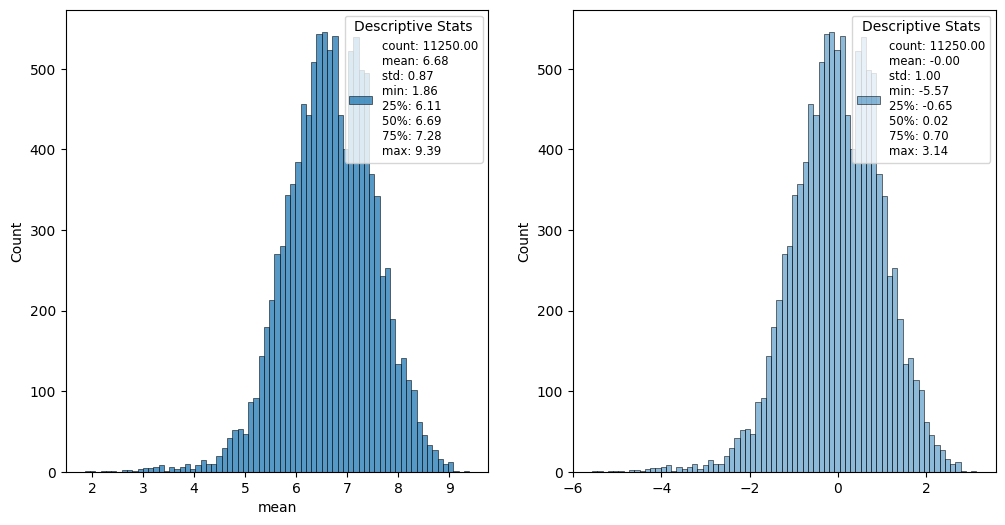

In [94]:
check_normal('mean')
standardize_analyze('mean')

no huge outliers, looks almost normal ==> use standardization for 'mean' column

Not Normal


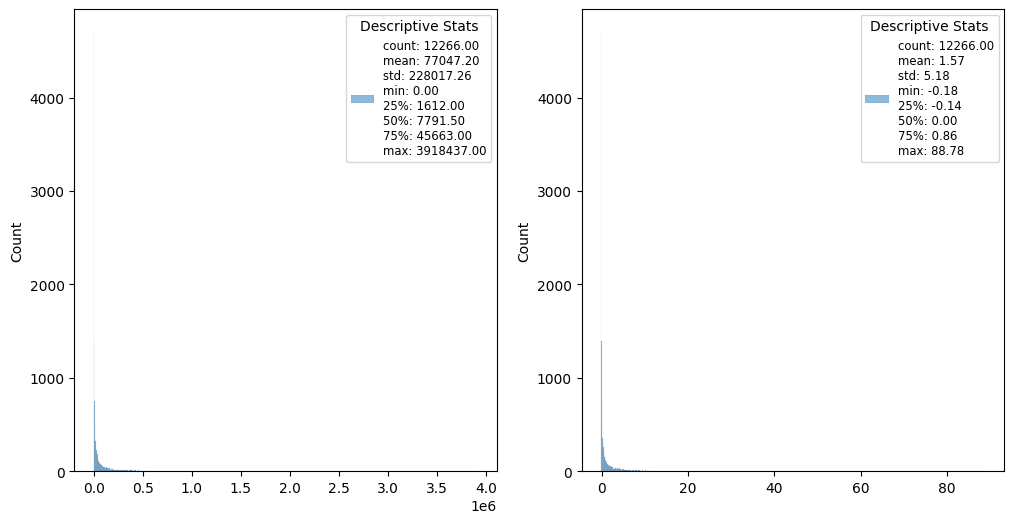

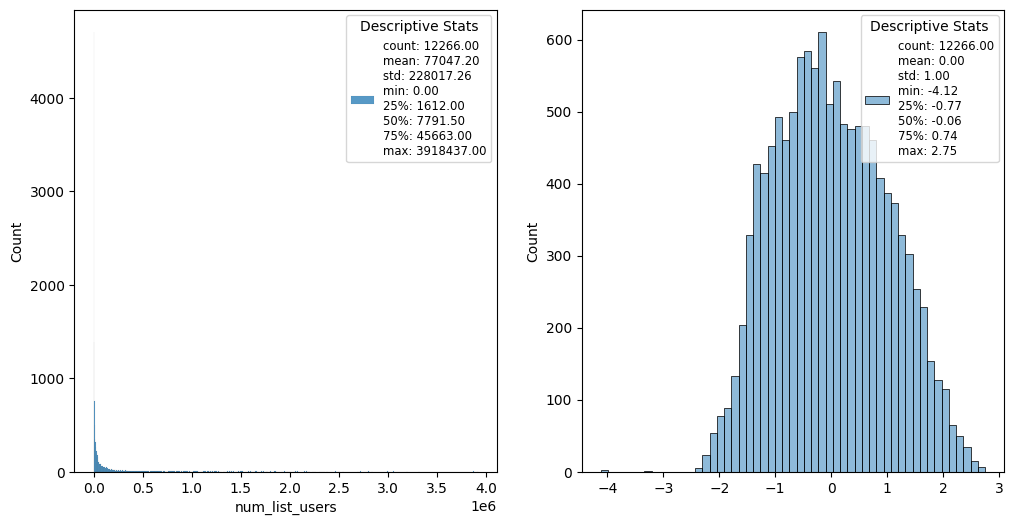

In [93]:
check_normal('num_list_users')
robust_analyze('num_list_users')
log_analyze('num_list_users')

many huge outliers ==> use log (and maybe also standardization) or robust scaling

Not Normal


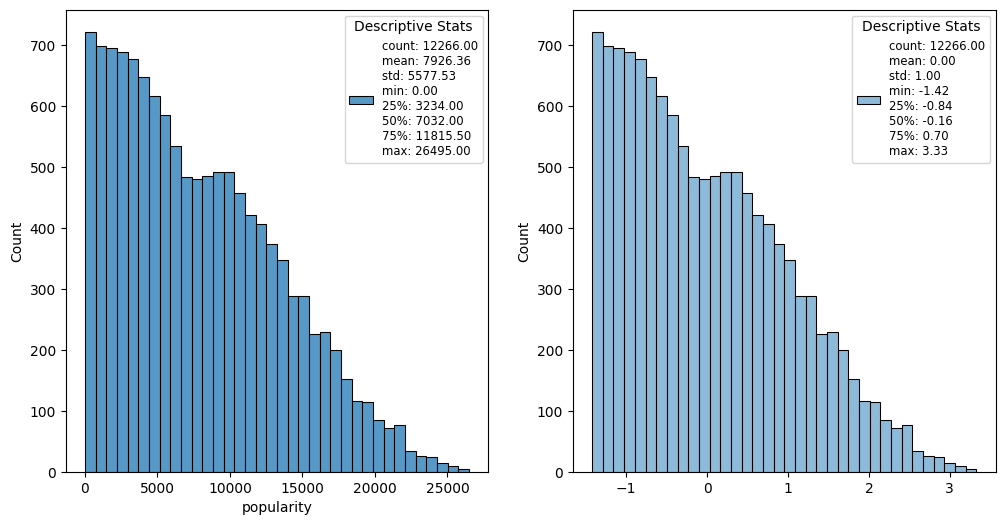

In [69]:
check_normal('popularity')
standardize_analyze('popularity')

few huge outliers ==> standardization

Not Normal


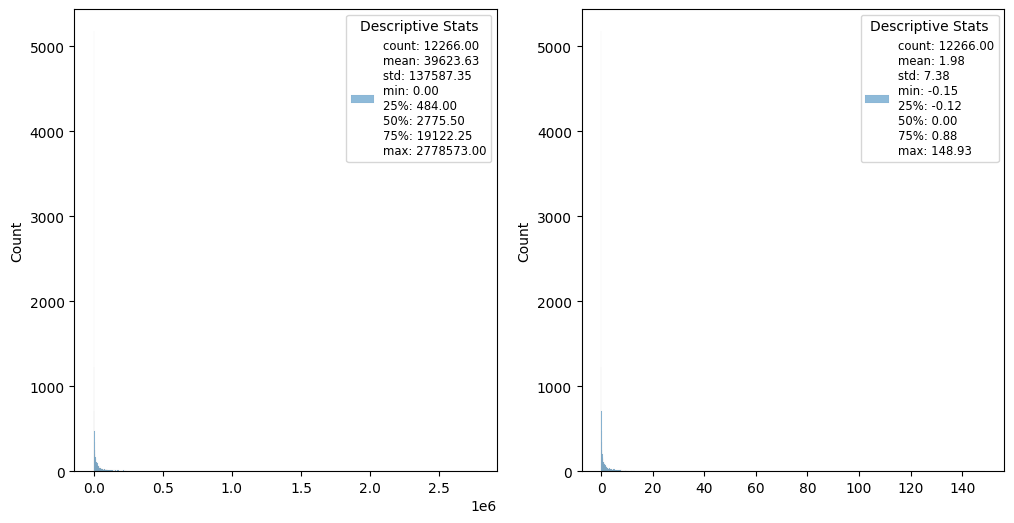

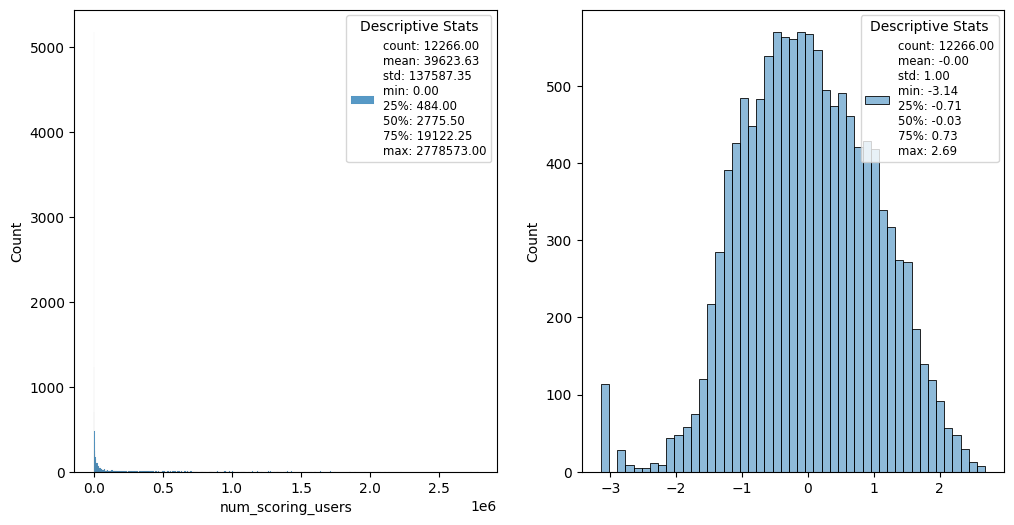

In [92]:
check_normal('num_scoring_users')
robust_analyze('num_scoring_users')
log_analyze('num_scoring_users')

many huge outliers ==> log (and maybe standardization) or robust scaling

Not Normal


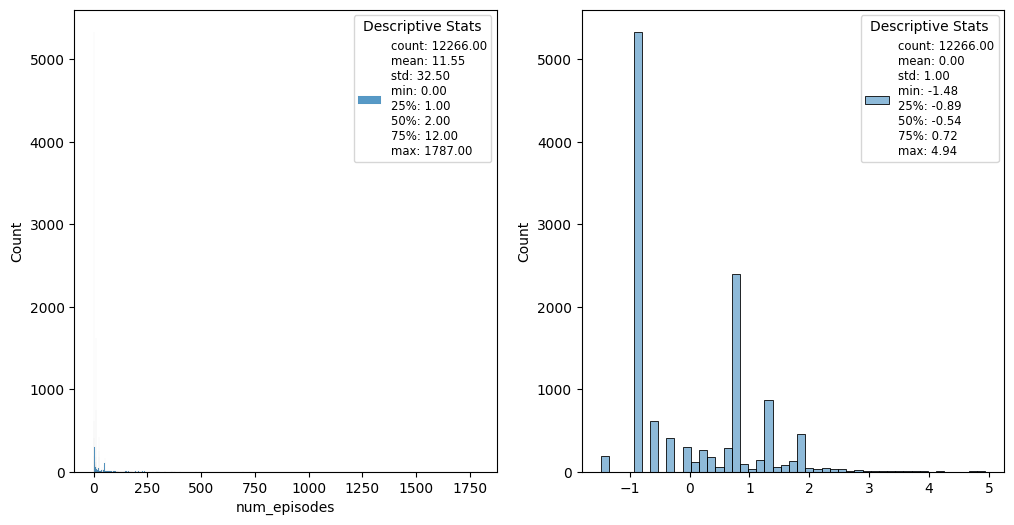

In [88]:
check_normal('num_episodes')
log_analyze('num_episodes', st=True)

huge outliers ==> log scaling (maybe also standardization) (probably not robust scaling, since it doesn't constrain the range of values enough)

Not Normal


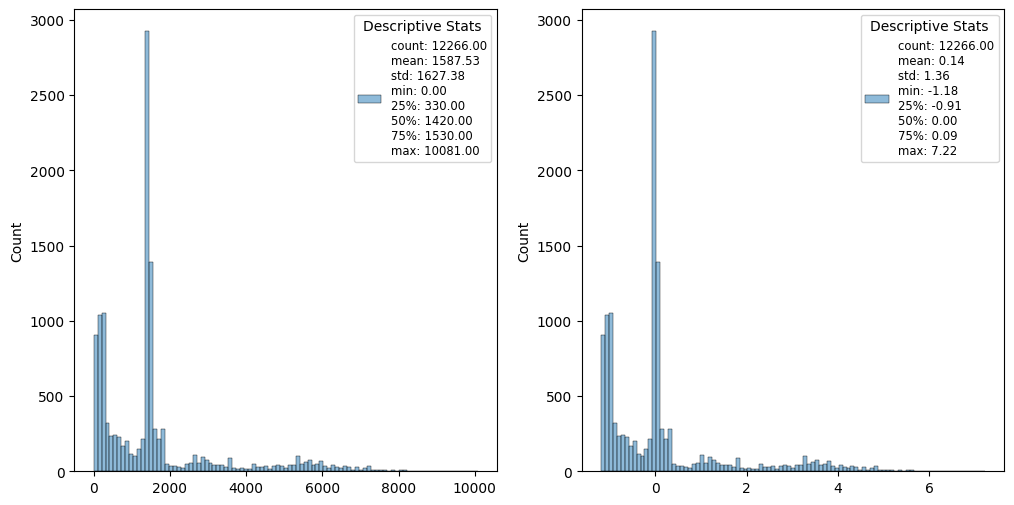

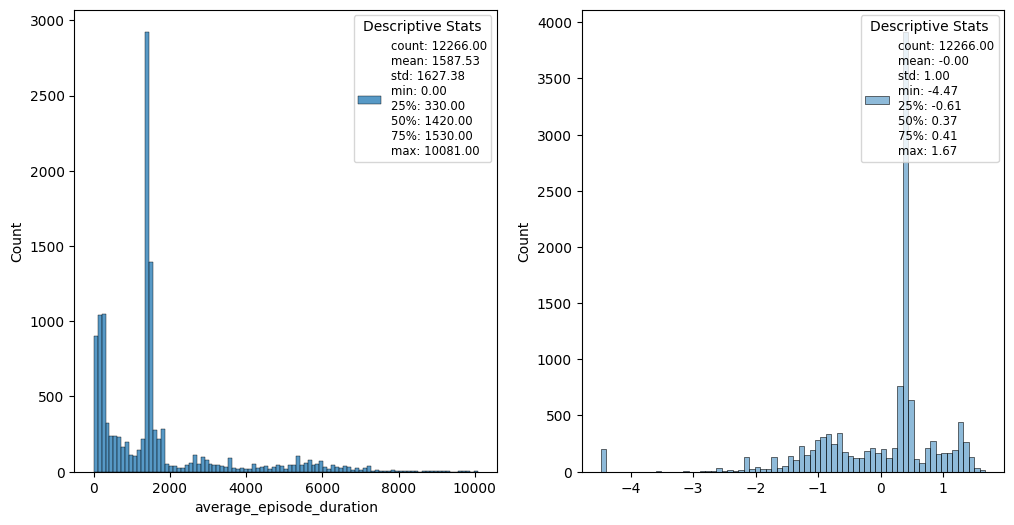

In [89]:
check_normal('average_episode_duration')
robust_analyze('average_episode_duration')
log_analyze('average_episode_duration', st=True)

big outliers / long tail of large values ==> try robust or log scaling (log with standardization)

## Analyze Date Information

In [4]:
# check what status animes are in where the start date is missing
raw_data[raw_data['start_date'].isna()]['status'].unique()

array(['not_yet_aired', 'finished_airing'], dtype=object)

In [69]:
def safe_date_convert(date) -> datetime.date:
    if pd.isna(date):
        return None
    if type(date) is float:
        return datetime.strptime(str(int(date)), '%Y').date()
    if type(date) is str:
        if re.compile("\d{4}-\d{2}-\d{2}").match(date):
            return datetime.strptime(date, '%Y-%m-%d').date()
        elif re.compile("\d{4}-\d{2}").search(date):
            return datetime.strptime(date, '%Y-%m').date()
        else:
            return datetime.strptime(date, '%Y').date()
    raise ValueError(f"Invalid date format: {date}, {type(date)}")

test = raw_data[['status', 'start_date', 'end_date', 'start_season.year', 'start_season.season']].dropna()
test['start_season.year'].apply(safe_date_convert)

0        2023-01-01
1        2009-01-01
2        2011-01-01
3        2015-01-01
4        2019-01-01
            ...    
12261    2022-01-01
12262    2022-01-01
12263    2022-01-01
12264    2022-01-01
12265    2022-01-01
Name: start_season.year, Length: 11628, dtype: object

### Test Encoding Start Season as a Cyclical Feature

In [89]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# Encode the 'start_season.season' column using LabelEncoder
encoder = LabelEncoder()

# Create a new DataFrame to store the encoded labels and cyclical features
encoded_data = raw_data.dropna().copy()
encoded_labels = encoder.fit_transform(encoded_data['start_season.season'])
encoded_data['encoded_season'] = encoded_labels

# Apply the cyclical_encode function to create sine and cosine features
encoded_data = cyclical_encode(encoded_data, 'encoded_season', max_val=len(encoder.classes_))

# Print the encoded and transformed data
print(encoded_data[['start_season.season', 'encoded_season', 'encoded_season_sin', 'encoded_season_cos']])


      start_season.season  encoded_season  encoded_season_sin  \
0                    fall               0        0.000000e+00   
1                  spring               1        1.000000e+00   
2                  spring               1        1.000000e+00   
3                  spring               1        1.000000e+00   
4                  spring               1        1.000000e+00   
...                   ...             ...                 ...   
12261              spring               1        1.000000e+00   
12262              spring               1        1.000000e+00   
12263              summer               2        1.224647e-16   
12264                fall               0        0.000000e+00   
12265                fall               0        0.000000e+00   

       encoded_season_cos  
0            1.000000e+00  
1            6.123234e-17  
2            6.123234e-17  
3            6.123234e-17  
4            6.123234e-17  
...                   ...  
12261        6.123234e-

In [94]:
encoded_data.drop_duplicates(subset=['start_season.season'])[['start_season.season', 'encoded_season_sin', 'encoded_season_cos']]

,start_season.season,encoded_season_sin,encoded_season_cos
0,fall,0.000000e+00,1.000000e+00
1,spring,1.000000e+00,6.123234e-17
5,winter,-1.000000e+00,-1.836970e-16
16,summer,1.224647e-16,-1.000000e+00


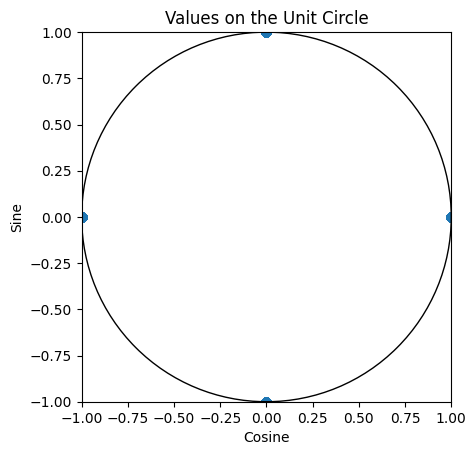

In [90]:
# Get the values from the columns
sin_values = encoded_data['encoded_season_sin']
cos_values = encoded_data['encoded_season_cos']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values on the unit circle
ax.scatter(cos_values, sin_values)

# Set the aspect ratio to equal
ax.set_aspect('equal')

# Set the limits of the plot
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add a unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(circle)

# Add labels and title
ax.set_xlabel('Cosine')
ax.set_ylabel('Sine')
ax.set_title('Values on the Unit Circle')

# Show the plot
plt.show()


### Using Start and End Date to Calculate Duration

In [70]:
def time_diff(start_date, end_date):
    if pd.isna(start_date) or pd.isna(end_date):
        return None
    return (end_date - start_date).days

converted = test
converted['start_date'] = converted['start_date'].apply(safe_date_convert)
converted['end_date'] = converted['end_date'].apply(safe_date_convert)
# calculate time difference
converted['time_diff'] = converted.apply(lambda x: time_diff(x['start_date'], x['end_date']), axis=1)

# swap start and end dates if time difference is negative
idx = converted['time_diff'] < 0
converted.loc[idx,['start_date','end_date']] = converted.loc[idx,['end_date','start_date']].values

# recalculate time difference
converted['time_diff'] = converted.apply(lambda x: time_diff(x['start_date'], x['end_date']), axis=1)

In [63]:
# check duration of animes where full date information is available
date_data = raw_data[raw_data['start_date'].notna() & raw_data['end_date'].notna()]
date_data = date_data[date_data['start_date'].str.contains('-.*-') & date_data['end_date'].str.contains('-.*-')]
date_data['start_date'] = pd.to_datetime(date_data['start_date'], yearfirst=True)
date_data['end_date'] = pd.to_datetime(date_data['end_date'], yearfirst=True)
date_data['duration'] = date_data['end_date'].dt.date - date_data['start_date'].dt.date
date_data['duration'] = date_data['duration'].apply(lambda x: x.days)

In [70]:
# check for negative durations
date_data.loc[(date_data['duration'] < 0), ['start_date', 'end_date']]

,start_date,end_date
9802,2009-12-14,2009-08-26
